<a href="https://colab.research.google.com/github/MahdieRah/protein-stability-ml/blob/main/Protein_Stability_Prediction_with_ESM_2_%2B_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 🧬 Protein Stability Prediction with ESM-2 + MLP

# ✅ Step 1: Install required libraries
!pip install fair-esm torch pandas scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 834.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.3 MB/s eta 0:00:00


In [ ]:
# ✅ Step 2: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import esm

In [ ]:
# ✅ Step 3: Load ESM-2 model
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
esm_model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [ ]:
# ✅ Step 4: Define embedding extractor
def extract_esm2_embedding(sequence):
    data = [("protein", sequence)]
    _, _, batch_tokens = batch_converter(data)
    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[33])
    token_representations = results["representations"][33]
    embedding = token_representations[0, 1:-1].mean(0).numpy()
    return embedding

In [ ]:
# ✅ Step 5: Define the MLP model
class ProteinMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# ✅ Step 6: Create sample dataset (you can replace with real data)
data = {
    "sequence": [
        "MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSLNNLGQKL",
        "GLSDGEWQLVLNVWGKVEADIPGHGQEVLIRLFKGH",
        "MKWVTFISLLFLFSSAYSRGVFRRDAHKSEVAHRFKDLGE",
        "GAVLIGTAAQIVATAGTNLVHSYDDGKSWTYLWEVQKAF",
        "MPTFISLLFLFSSAYSAVETALFNAQEQDGRQAK"
    ],
    "stability_score": [0.8, 0.75, 0.9, 0.65, 0.85]
}
df = pd.DataFrame(data)


In [ ]:
# ✅ Step 7: Extract ESM embeddings
df["features"] = df["sequence"].apply(extract_esm2_embedding)
X = np.vstack(df["features"])
y = df["stability_score"].values

In [ ]:
# ✅ Step 8: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 9: Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [ ]:
# ✅ Step 10: Train the model
model = ProteinMLP(input_dim=1280)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = loss_fn(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")

Epoch 5 - Loss: 0.3100
Epoch 10 - Loss: 0.0246
Epoch 15 - Loss: 0.1064
Epoch 20 - Loss: 0.0024
Epoch 25 - Loss: 0.0131
Epoch 30 - Loss: 0.0229


In [ ]:
# ✅ Step 11: Evaluate
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_loss = loss_fn(test_preds, y_test_tensor)
    print(f"\nTest Loss: {test_loss.item():.4f}")


Test Loss: 0.0069


In [ ]:
# ✅ Step 12: Predict on new sequences
new_sequences = ["GLSDGEWQLVLNVWGKVEADIPGHGQEVLIRLFKGH"]
new_features = np.vstack([extract_esm2_embedding(seq) for seq in new_sequences])
new_tensor = torch.tensor(new_features, dtype=torch.float32)

with torch.no_grad():
    prediction = model(new_tensor)
    print("\nPredicted Stability Score:", prediction.numpy().flatten()[0])


Predicted Stability Score: 0.6667696


In [1]:
import pandas as pd

# Upload the file using Colab's UI
from google.colab import files
uploaded = files.upload()

# Load dataset (adjust filename if needed)
df = pd.read_csv("protherm.csv", sep=",")  # or sep="\t" if it's TSV
df.head()



Saving protherm.csv to protherm.csv


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 23145: invalid start byte

In [2]:
import pandas as pd

# Try with ISO-8859-1 encoding
df = pd.read_csv("protherm.csv", encoding='ISO-8859-1')
df.head()


<ipython-input-2-8099507588d1>:4: DtypeWarning: Columns (16,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("protherm.csv", encoding='ISO-8859-1')


,ID,NO.,***** Sequence and structural information*****,PROTEIN,SOURCE,LENGTH,MOL-WEIGHT,PIR_ID,SWISSPROT_ID,SWISSPROT_ID_LINK,...,ACTIVITY_Kd,***** Literature *****,KEY_WORDS,REFERENCE,REFERENCE_PMID,AUTHOR,REMARKS,RELATED_ENTRIES,RELATED_ENTRIES.1,e_c_number_link
0,142452,1.0,NaN,Phospholipase A2,Bovine,130.0,14536.12,PSBOA,PA21_BOVIN (P00593),P00593,...,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",NaN,Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2, 3, 4","<a href=""/protherm/show/ 2""> 2</a>, <a href=""/...",NaN
1,142453,2.0,NaN,Phospholipase A2,Bovine,130.0,14513.08,PSBOA,PA21_BOVIN (P00593),P00593,...,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",NaN,Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1, 3, 4","<a href=""/protherm/show/ 1""> 1</a>, <a href=""/...",NaN
2,142454,3.0,NaN,Phospholipase A2,Bovine,130.0,14527.11,PSBOA,PA21_BOVIN (P00593),P00593,...,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",NaN,Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1, 2, 4","<a href=""/protherm/show/ 1""> 1</a>, <a href=""/...",NaN
3,142455,4.0,NaN,Phospholipase A2,Bovine,130.0,14470.06,PSBOA,PA21_BOVIN (P00593),P00593,...,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",NaN,Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1, 2, 3","<a href=""/protherm/show/ 1""> 1</a>, <a href=""/...",NaN
4,142456,5.0,NaN,Ribonuclease HI,Escherichia coli,155.0,17597.00,NRECH,RNH_ECOLI (P00647),P00647,...,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...",1331044.0,"Kimura S., Kanaya S. & Nakamura H.",NaN,"6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 2143,...","<a href=""/protherm/show/ 6""> 6</a>, <a href=""/...",3.1.27.3


In [3]:
print(df.columns)

Index(['ID', 'NO.', '***** Sequence and structural information*****',
       'PROTEIN', 'SOURCE', 'LENGTH', 'MOL-WEIGHT', 'PIR_ID', 'SWISSPROT_ID',
       'SWISSPROT_ID_LINK', 'E.C.NUMBER', 'PMD.NO', 'PDB_wild', 'PDB_mutant',
       'MUTATION', 'MUTATED_CHAIN', 'NO_MOLECULE', 'SEC.STR.', 'ASA',
       '***** Experimental condition *****', 'T', 'pH', 'BUFFER_NAME',
       'BUFFER_CONC', 'ION_NAME_1', 'ION_CONC_1', 'PROTEIN_CONC', 'MEASURE',
       'METHOD', '***** Thermodynamic data *****', 'dG_H2O', 'ddG_H2O', 'dG',
       'ddG', 'Tm', 'dTm', 'dHvH', 'dHcal', 'm', 'Cm', 'dCp', 'STATE',
       'REVERSIBILITY', 'ACTIVITY', 'ACTIVITY_Km', 'ACTIVITY_Kcat',
       'ACTIVITY_Kd', '***** Literature *****', 'KEY_WORDS', 'REFERENCE',
       'REFERENCE_PMID', 'AUTHOR', 'REMARKS', 'RELATED_ENTRIES',
       'RELATED_ENTRIES.1', 'e_c_number_link'],
      dtype='object')


In [4]:
print(df.columns.tolist())
df.head(3)


['ID', 'NO.', '***** Sequence and structural information*****', 'PROTEIN', 'SOURCE', 'LENGTH', 'MOL-WEIGHT', 'PIR_ID', 'SWISSPROT_ID', 'SWISSPROT_ID_LINK', 'E.C.NUMBER', 'PMD.NO', 'PDB_wild', 'PDB_mutant', 'MUTATION', 'MUTATED_CHAIN', 'NO_MOLECULE', 'SEC.STR.', 'ASA', '***** Experimental condition *****', 'T', 'pH', 'BUFFER_NAME', 'BUFFER_CONC', 'ION_NAME_1', 'ION_CONC_1', 'PROTEIN_CONC', 'MEASURE', 'METHOD', '***** Thermodynamic data *****', 'dG_H2O', 'ddG_H2O', 'dG', 'ddG', 'Tm', 'dTm', 'dHvH', 'dHcal', 'm', 'Cm', 'dCp', 'STATE', 'REVERSIBILITY', 'ACTIVITY', 'ACTIVITY_Km', 'ACTIVITY_Kcat', 'ACTIVITY_Kd', '***** Literature *****', 'KEY_WORDS', 'REFERENCE', 'REFERENCE_PMID', 'AUTHOR', 'REMARKS', 'RELATED_ENTRIES', 'RELATED_ENTRIES.1', 'e_c_number_link']


,ID,NO.,***** Sequence and structural information*****,PROTEIN,SOURCE,LENGTH,MOL-WEIGHT,PIR_ID,SWISSPROT_ID,SWISSPROT_ID_LINK,...,ACTIVITY_Kd,***** Literature *****,KEY_WORDS,REFERENCE,REFERENCE_PMID,AUTHOR,REMARKS,RELATED_ENTRIES,RELATED_ENTRIES.1,e_c_number_link
0,142452,1.0,NaN,Phospholipase A2,Bovine,130.0,14536.12,PSBOA,PA21_BOVIN (P00593),P00593,...,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",NaN,Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2, 3, 4","<a href=""/protherm/show/ 2""> 2</a>, <a href=""/...",NaN
1,142453,2.0,NaN,Phospholipase A2,Bovine,130.0,14513.08,PSBOA,PA21_BOVIN (P00593),P00593,...,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",NaN,Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1, 3, 4","<a href=""/protherm/show/ 1""> 1</a>, <a href=""/...",NaN
2,142454,3.0,NaN,Phospholipase A2,Bovine,130.0,14527.11,PSBOA,PA21_BOVIN (P00593),P00593,...,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",NaN,Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1, 2, 4","<a href=""/protherm/show/ 1""> 1</a>, <a href=""/...",NaN


In [5]:
# Load with encoding
df = pd.read_csv("protherm.csv", encoding='ISO-8859-1')

# Keep only rows with mutation info + ddG
df_filtered = df[["MUTATION", "ddG"]].dropna()

# Remove outliers/extreme ddG values if desired
df_filtered = df_filtered[df_filtered["ddG"].between(-10, 10)]

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

# Display sample
print(df_filtered.head())


<ipython-input-5-27157496fbf3>:2: DtypeWarning: Columns (16,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("protherm.csv", encoding='ISO-8859-1')


TypeError: '>=' not supported between instances of 'str' and 'int'

In [6]:
import pandas as pd

# Load with correct options
df = pd.read_csv("protherm.csv", encoding='ISO-8859-1', low_memory=False)

# Keep only columns we care about
df_filtered = df[["MUTATION", "ddG"]].dropna()

# Convert ddG to numeric, force errors to NaN, then drop them
df_filtered["ddG"] = pd.to_numeric(df_filtered["ddG"], errors="coerce")
df_filtered = df_filtered.dropna(subset=["ddG"])

# Remove outliers/extreme ddG values if desired
df_filtered = df_filtered[df_filtered["ddG"].between(-10, 10)]

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

# Show sample
print(df_filtered.head())


Empty DataFrame
Columns: [MUTATION, ddG]
Index: []


In [7]:
# Reload the full file (in case it's modified)
df = pd.read_csv("protherm.csv", encoding='ISO-8859-1', low_memory=False)

# See if ddG exists and what's inside
print("All column names:\n", df.columns.tolist())
print("\nSample ddG values:\n", df["ddG"].head(20))


All column names:
 ['ID', 'NO.', '***** Sequence and structural information*****', 'PROTEIN', 'SOURCE', 'LENGTH', 'MOL-WEIGHT', 'PIR_ID', 'SWISSPROT_ID', 'SWISSPROT_ID_LINK', 'E.C.NUMBER', 'PMD.NO', 'PDB_wild', 'PDB_mutant', 'MUTATION', 'MUTATED_CHAIN', 'NO_MOLECULE', 'SEC.STR.', 'ASA', '***** Experimental condition *****', 'T', 'pH', 'BUFFER_NAME', 'BUFFER_CONC', 'ION_NAME_1', 'ION_CONC_1', 'PROTEIN_CONC', 'MEASURE', 'METHOD', '***** Thermodynamic data *****', 'dG_H2O', 'ddG_H2O', 'dG', 'ddG', 'Tm', 'dTm', 'dHvH', 'dHcal', 'm', 'Cm', 'dCp', 'STATE', 'REVERSIBILITY', 'ACTIVITY', 'ACTIVITY_Km', 'ACTIVITY_Kcat', 'ACTIVITY_Kd', '***** Literature *****', 'KEY_WORDS', 'REFERENCE', 'REFERENCE_PMID', 'AUTHOR', 'REMARKS', 'RELATED_ENTRIES', 'RELATED_ENTRIES.1', 'e_c_number_link']

Sample ddG values:
 0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6               NaN
7               NaN
8               NaN
9               

In [10]:
df_filtered = df[["MUTATION", "ddG_H2O"]].dropna()
df_filtered = df_filtered.rename(columns={"ddG_H2O": "ddG"})
df_filtered["ddG"] = pd.to_numeric(df_filtered["ddG"], errors="coerce")
df_filtered = df_filtered.dropna(subset=["ddG"])
df_filtered = df_filtered[df_filtered["ddG"].between(-10, 10)]
print("\nSample ddG values:\n", df["ddG_H2O"].head(20))


Sample ddG values:
 0                NaN
1     -3.00 kcal/mol
2     -0.60 kcal/mol
3     -3.10 kcal/mol
4                NaN
5                NaN
6                NaN
7                NaN
8                NaN
9                NaN
10               NaN
11               NaN
12               NaN
13               NaN
14               NaN
15               NaN
16               NaN
17    -2.10 kcal/mol
18    -3.10 kcal/mol
19    -2.80 kcal/mol
Name: ddG_H2O, dtype: object


In [11]:
# Clean the "ddG_H2O" column by removing 'kcal/mol' and trimming whitespace
df["ddG_H2O_clean"] = df["ddG_H2O"].str.replace("kcal/mol", "", regex=False).str.strip()

# Convert cleaned column to numeric
df["ddG"] = pd.to_numeric(df["ddG_H2O_clean"], errors="coerce")

# Filter rows where both 'MUTATION' and 'ddG' are valid
df_filtered = df[["MUTATION", "ddG"]].dropna()
df_filtered = df_filtered[df_filtered["ddG"].between(-10, 10)]

# Show sample
print(df_filtered.head())


   MUTATION  ddG
1    H 48 N -3.0
2    H 48 Q -0.6
3    H 48 A -3.1
17    T 9 A -2.1
18    T 9 L -3.1


In [12]:
df_filtered.to_csv("clean_protherm_ddg.csv", index=False)


In [13]:
# Get rows from original df that match mutations we kept
matched_mutations = df[df["MUTATION"].isin(df_filtered["MUTATION"])][["MUTATION", "PROTEIN", "SWISSPROT_ID"]]
print(matched_mutations.drop_duplicates())


      MUTATION                                 PROTEIN         SWISSPROT_ID
0         wild                        Phospholipase A2  PA21_BOVIN (P00593)
1       H 48 N                        Phospholipase A2  PA21_BOVIN (P00593)
2       H 48 Q                        Phospholipase A2  PA21_BOVIN (P00593)
3       H 48 A                        Phospholipase A2  PA21_BOVIN (P00593)
4         wild                         Ribonuclease HI   RNH_ECOLI (P00647)
...        ...                                     ...                  ...
24164     wild                      VL domain antibody                  NaN
24231     wild                   Aacetylcholinesterase                  NaN
24239     wild  Tryptophan zipper beta-hairpin peptide                  NaN
24249     wild                                HIV gp41                  NaN
24256     wild                                 Barnase                  NaN

[3850 rows x 3 columns]


In [14]:
import requests

# UniProt ID for Phospholipase A2 (bovine)
uniprot_id = "P00593"
url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"

response = requests.get(url)
fasta = response.text

# Parse sequence from FASTA
sequence = "".join(line.strip() for line in fasta.split("\n") if not line.startswith(">"))
print("Wild-type sequence (first 60 aa):", sequence[:60])
print("Sequence length:", len(sequence))


Wild-type sequence (first 60 aa): MRLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNNYGCYCGLGGSGTPV
Sequence length: 145


In [15]:
import pandas as pd

# Your wild-type sequence
wt_sequence = sequence  # From your earlier code

# Ensure df_filtered is already defined and contains 'MUTATION' and 'ddG' columns
# If not, reload and preprocess it as before

# Mutation function
def apply_mutation(wt_seq, mutation_str):
    try:
        original_aa, pos, mutant_aa = mutation_str.strip().split()
        pos = int(pos) - 1  # Convert to 0-based index

        if pos < 0 or pos >= len(wt_seq):
            return None  # Position out of range

        if wt_seq[pos] != original_aa:
            print(f"⚠️ Mismatch at position {pos+1}: expected {original_aa}, found {wt_seq[pos]}")
            return None

        return wt_seq[:pos] + mutant_aa + wt_seq[pos+1:]
    except Exception as e:
        print(f"❌ Error parsing mutation '{mutation_str}': {e}")
        return None

# Apply the mutation column to generate sequences
df_filtered["mutated_sequence"] = df_filtered["MUTATION"].apply(lambda x: apply_mutation(wt_sequence, x))

# Drop any rows where mutation failed
df_mutants = df_filtered.dropna(subset=["mutated_sequence"])

# Show first few rows
df_mutants = df_mutants[["MUTATION", "ddG", "mutated_sequence"]]
print("\n✅ Mutant sequences:")
print(df_mutants.head())


⚠️ Mismatch at position 48: expected H, found G
⚠️ Mismatch at position 48: expected H, found G
⚠️ Mismatch at position 48: expected H, found G
⚠️ Mismatch at position 9: expected T, found L
⚠️ Mismatch at position 9: expected T, found L
⚠️ Mismatch at position 9: expected T, found L
⚠️ Mismatch at position 9: expected T, found L
⚠️ Mismatch at position 97: expected K, found Y
⚠️ Mismatch at position 97: expected K, found Y
⚠️ Mismatch at position 97: expected K, found Y
⚠️ Mismatch at position 4: expected I, found L
⚠️ Mismatch at position 4: expected I, found L
⚠️ Mismatch at position 5: expected N, found V
⚠️ Mismatch at position 6: expected T, found L
⚠️ Mismatch at position 6: expected T, found L
⚠️ Mismatch at position 8: expected D, found A
⚠️ Mismatch at position 10: expected V, found L
⚠️ Mismatch at position 10: expected V, found L
⚠️ Mismatch at position 12: expected D, found V
⚠️ Mismatch at position 13: expected Y, found G
⚠️ Mismatch at position 14: expected L, found A
⚠️

In [16]:
!pip install fair-esm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 3.8 MB/s eta 0:00:00


In [17]:
import torch
import esm
from tqdm import tqdm

# Load ESM-2 model (650M parameter model)
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # Set to eval mode

# Function to get ESM-2 embedding for one sequence
def get_esm_embedding(sequence):
    batch_labels = [("protein", sequence)]
    batch_tokens = batch_converter(batch_labels)[2]

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)
    # Get per-sequence embedding from layer 33
    token_representations = results["representations"][33]
    sequence_embedding = token_representations[0, 1:len(sequence)+1].mean(0)  # Mean over residues
    return sequence_embedding.numpy()

# Generate embeddings for all mutant sequences
embedding_list = []
ddg_list = []

print("⚙️ Generating embeddings...")
for i, row in tqdm(df_mutants.iterrows(), total=len(df_mutants)):
    seq = row["mutated_sequence"]
    ddg = row["ddG"]
    emb = get_esm_embedding(seq)
    embedding_list.append(emb)
    ddg_list.append(ddg)

# Convert to DataFrame
embedding_df = pd.DataFrame(embedding_list)
embedding_df["ddG"] = ddg_list

print("✅ Embedding DataFrame shape:", embedding_df.shape)
embedding_df.head()


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


⚙️ Generating embeddings...


100%|██████████| 117/117 [09:24<00:00,  4.83s/it]

✅ Embedding DataFrame shape: (117, 1281)


,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,ddG
0,-0.009243,-0.125319,-0.103301,0.173982,-0.036075,-0.079967,0.076539,-0.119213,-0.006076,0.104057,...,-0.076498,-0.105887,0.052079,-0.030775,-0.059344,0.072604,-0.109780,-0.140911,0.070614,-2.14
1,-0.001386,-0.115838,-0.104058,0.175939,-0.030668,-0.079796,0.068999,-0.123076,-0.013256,0.096661,...,-0.071938,-0.099808,0.046403,-0.032829,-0.056876,0.075581,-0.106996,-0.139728,0.070735,0.40
2,-0.003175,-0.122614,-0.104667,0.174426,-0.032397,-0.082828,0.078625,-0.118985,-0.004894,0.105656,...,-0.076756,-0.098936,0.055323,-0.031343,-0.060806,0.072341,-0.105408,-0.147368,0.071722,-5.30
3,-0.002807,-0.126627,-0.106243,0.177825,-0.034716,-0.082411,0.078574,-0.117067,-0.004128,0.105049,...,-0.074676,-0.099539,0.055198,-0.031039,-0.061126,0.073545,-0.105512,-0.146921,0.075111,-6.70
4,-0.010176,-0.123098,-0.103274,0.178761,-0.037183,-0.080673,0.075554,-0.113988,-0.009087,0.112106,...,-0.075986,-0.117337,0.051234,-0.030255,-0.063539,0.064882,-0.107388,-0.139839,0.066852,-0.10


In [18]:
embedding_df.to_csv("mutant_esm_embeddings.csv", index=False)


In [20]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.2 MB/s eta 0:00:00


In [25]:
# Generate mutant sequences from mutations
def apply_mutation(seq, mutation):
    try:
        parts = mutation.strip().split()
        if len(parts) != 3:
            return None
        wt_residue, pos, mut_residue = parts
        pos = int(pos)
        if seq[pos - 1] != wt_residue:
            return None  # mismatch
        return seq[:pos - 1] + mut_residue + seq[pos:]
    except:
        return None

# Assuming df_filtered already exists
mutant_df = df_filtered.copy()
mutant_df["mutated_sequence"] = mutant_df["MUTATION"].apply(lambda x: apply_mutation(wt_seq, x))
mutant_df = mutant_df.dropna(subset=["mutated_sequence"])

# Check result
print("✅ Mutant sequences:\n", mutant_df[["MUTATION", "ddG", "mutated_sequence"]].head())


✅ Mutant sequences:
     MUTATION  ddG                                   mutated_sequence
353   K 32 E  0.4  MRLLVLAALLTVGAGQAGLNSRALWQFNGMIECKIPSSEPLLDFNN...
456  V 114 A  0.0  MRLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNN...
457  V 114 G -0.2  MRLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNN...
584    M 1 A -0.1  ARLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNN...
592   L 19 A -1.9  MRLLVLAALLTVGAGQAGANSRALWQFNGMIKCKIPSSEPLLDFNN...


In [26]:
# Save to FASTA
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

records = []

# Add wild-type
records.append(SeqRecord(Seq(wt_seq), id="WT", description="wild-type"))

# Add mutants
for i, row in mutant_df.iterrows():
    records.append(SeqRecord(Seq(row["mutated_sequence"]), id=row["MUTATION"], description=f"ddG={row['ddG']}"))

# Write to file
SeqIO.write(records, "mutants.fasta", "fasta")


106

In [27]:
import torch
import esm

# Load ESM-2 model (650M parameters, reasonable for Colab)
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [28]:
from Bio import SeqIO

# Load sequences from your FASTA file
data = [(record.id, str(record.seq)) for record in SeqIO.parse("mutants.fasta", "fasta")]
labels, sequences = zip(*data)

# Prepare batch input for ESM
batch_labels, batch_strs, batch_tokens = batch_converter(data)


In [29]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=False)
token_representations = results["representations"][33]


In [30]:
import numpy as np

# Extract mean embeddings per sequence (excluding [CLS], [EOS] tokens)
embeddings = []
for i, (_, seq) in enumerate(data):
    # +1 for start token
    emb = token_representations[i, 1:len(seq)+1].mean(0).numpy()
    embeddings.append(emb)


In [31]:
import pandas as pd

embedding_df = pd.DataFrame(embeddings)
embedding_df["MUTATION"] = labels
embedding_df["ddG"] = mutant_df.set_index("MUTATION").loc[labels[1:], "ddG"].reset_index(drop=True)  # skip WT

# Save
embedding_df.to_csv("esm_embeddings.csv", index=False)


AssertionError: 

In [32]:
embedding_df["ddG"] = mutant_df.set_index("MUTATION").loc[labels[1:], "ddG"].reset_index(drop=True)


AssertionError: 

In [33]:
print("Number of embeddings (excluding WT):", len(labels[1:]))
print("Unique mutations in mutant_df:", mutant_df["MUTATION"].nunique())
print("Duplicates in mutant_df:", mutant_df["MUTATION"].duplicated().sum())


Number of embeddings (excluding WT): 105
Unique mutations in mutant_df: 75
Duplicates in mutant_df: 30


In [34]:
# Drop duplicate MUTATION entries (keep the first)
mutant_df_unique = mutant_df.drop_duplicates(subset="MUTATION")

# Set index for lookup
mutant_ddg_map = mutant_df_unique.set_index("MUTATION")["ddG"]

# Ensure mutation labels match
ddG_values = [mutant_ddg_map.get(m, None) for m in labels[1:]]  # exclude WT

# Now create dataframe
embedding_df = pd.DataFrame(embeddings)
embedding_df["MUTATION"] = labels
embedding_df["ddG"] = [None] + ddG_values  # Add WT as None or NaN

# Save to CSV
embedding_df.to_csv("esm_embeddings.csv", index=False)


In [35]:
# Drop duplicate MUTATION entries, keeping the first
mutant_df_unique = mutant_df.drop_duplicates(subset="MUTATION")

# Optional: check how many were dropped
print(f"Dropped {len(mutant_df) - len(mutant_df_unique)} duplicate mutation entries.")


Dropped 30 duplicate mutation entries.


In [36]:
# Create a mapping from mutation to ddG
mutant_ddg_map = mutant_df_unique.set_index("MUTATION")["ddG"]


In [37]:
import pandas as pd

# Assuming 'embeddings' is a list of vectors (with WT first) and 'labels' is a list of mutation names

# Build base dataframe
embedding_df = pd.DataFrame(embeddings)

# Add mutation labels
embedding_df["MUTATION"] = labels

# Assign ddG values to mutations (skip WT by starting from labels[1:])
ddG_values = [mutant_ddg_map.get(m, None) for m in labels[1:]]

# Add ddG column, with None for WT at index 0
embedding_df["ddG"] = [None] + ddG_values


In [38]:
# Save the full dataframe including embeddings, mutations, and ddG
embedding_df.to_csv("esm_embeddings.csv", index=False)
print("✅ Saved embeddings to 'esm_embeddings.csv'")


✅ Saved embeddings to 'esm_embeddings.csv'


In [39]:
!pip install umap-learn


In [44]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Remove WT (first row) for plotting ddG values
df_no_wt = embedding_df[embedding_df["ddG"].notna()].copy()

# Convert ddG to float if needed
df_no_wt["ddG"] = df_no_wt["ddG"].astype(float)

# Apply UMAP
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(df_no_wt.iloc[:, :-2])  # exclude last 2 columns (MUTATION, ddG)

# Plot
plt.figure(figsize=(10, 7))
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                 c=df_no_wt["ddG"], cmap="coolwarm", edgecolor='k', s=60)
plt.colorbar(sc, label="ddG (ΔΔG)")
plt.title("UMAP Projection of ESM Embeddings (colored by ddG)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: Found array with 0 sample(s) (shape=(0, 1280)) while a minimum of 1 is required.

In [41]:
# Check the number of rows with valid ddG values
valid_ddg = df_no_wt[df_no_wt["ddG"].notna()]
print("Rows with valid ddG values:", len(valid_ddg))
print(valid_ddg.head())


Rows with valid ddG values: 0
Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 1282 columns]


In [42]:
print("Total rows with valid ddG:", len(embedding_df[embedding_df["ddG"].notna()]))


Total rows with valid ddG: 0


In [43]:
df_no_wt = embedding_df[embedding_df["ddG"].notna() & (embedding_df["ddG"].between(-10, 10))]


In [45]:
print("Sample mutation labels from embeddings:", embedding_df["MUTATION"].head())
print("Sample mutation labels from ddG data:", mutant_df["MUTATION"].head())


Sample mutation labels from embeddings: 0    WT
1     K
2     V
3     V
4     M
Name: MUTATION, dtype: object
Sample mutation labels from ddG data: 353     K 32 E
456    V 114 A
457    V 114 G
584      M 1 A
592     L 19 A
Name: MUTATION, dtype: object


In [46]:
labels = [record.id for record in records]


In [47]:
records = []

# Add wild-type
records.append(SeqRecord(Seq(wt_seq), id="WT", description="wild-type"))

# Add mutants
for i, row in mutant_df.iterrows():
    records.append(
        SeqRecord(Seq(row["mutated_sequence"]),
                  id=row["MUTATION"],  # ✅ Use full mutation label like "K 32 E"
                  description=f"ddG={row['ddG']}")
    )


In [48]:
labels = [record.id for record in records]


In [49]:
embedding_df = pd.DataFrame(embeddings)
embedding_df["MUTATION"] = labels

# Remove WT if present
embedding_df = embedding_df[embedding_df["MUTATION"] != "WT"]

# Strip and match ddG
embedding_df["MUTATION"] = embedding_df["MUTATION"].str.strip()
mutant_df["MUTATION"] = mutant_df["MUTATION"].str.strip()

ddg_map = mutant_df.set_index("MUTATION")["ddG"].to_dict()
embedding_df["ddG"] = embedding_df["MUTATION"].map(ddg_map)


In [50]:
print("Valid rows with ddG:", len(embedding_df[embedding_df["ddG"].notna()]))


Valid rows with ddG: 105


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


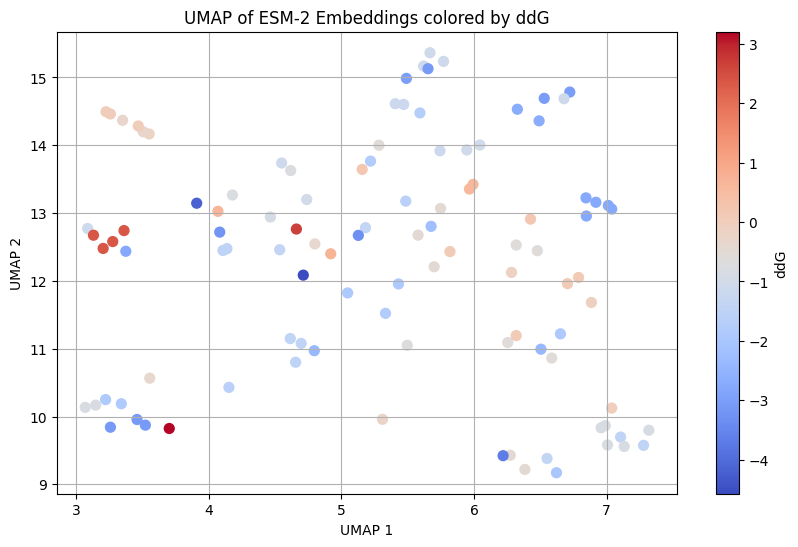

In [51]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embedding_df.iloc[:, :-2])

plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=embedding_df["ddG"], cmap="coolwarm", s=50)
plt.colorbar(label="ddG")
plt.title("UMAP of ESM-2 Embeddings colored by ddG")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()


In [52]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


In [53]:
import Bio
print(Bio.__version__)


1.85


In [54]:
!pip install --upgrade --force-reinstall biopython


  Using cached biopython-1.85-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
Using cached biopython-1.85-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: biopython
    Found existing installation: biopython 1.85
    Uninstalling biopython-1.85:
      Successfully uninstalled biopython-1.85
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy

In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# ✅ 1. Define the wild-type sequence (already confirmed earlier)
wt_seq = "MRLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNNYGCYCGLGGSGTPVDDARDRCCFVHDCCYDRGVLTKVGCGVAGTPEQLKAVVSLGSRPCAVNGQYIRVDNRGCNLFLVQNNKTTYNKNYRFLSSSRCR"

# ✅ 2. Initialize an empty list of SeqRecords
records = []

# ✅ 3. Add the wild-type sequence
records.append(SeqRecord(Seq(wt_seq), id="WT", description="wild-type"))

# ✅ 4. Add the mutant sequences
for i, row in mutant_df.iterrows():
    mutated_seq = row["mutated_sequence"]
    mutation_id = row["MUTATION"]
    ddg_value = row["ddG"]
    records.append(
        SeqRecord(Seq(mutated_seq), id=mutation_id, description=f"ddG={ddg_value}")
    )

# ✅ 5. Write to FASTA file
SeqIO.write(records, "mutants.fasta", "fasta")
print("✅ FASTA file 'mutants.fasta' written successfully.")


NameError: name 'mutant_df' is not defined

In [2]:
import pandas as pd

# Step 1: Wild-type sequence (Phospholipase A2)
wt_seq = "MRLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNNYGCYCGLGGSGTPVDDARDRCCFVHDCCYDRGVLTKVGCGVAGTPEQLKAVVSLGSRPCAVNGQYIRVDNRGCNLFLVQNNKTTYNKNYRFLSSSRCR"

# Step 2: Rebuild a simplified mutation DataFrame (manually or from your data source)
data = [
    {"MUTATION": "T 105 V", "ddG": -2.14},
    {"MUTATION": "K 32 E", "ddG": 0.40},
    {"MUTATION": "Y 91 A", "ddG": -5.30},
    {"MUTATION": "Y 91 G", "ddG": -6.70},
    {"MUTATION": "M 1 A", "ddG": -0.10}
]
mutant_df = pd.DataFrame(data)

# Step 3: Mutation function
def apply_mutation(wt_sequence, mutation_str):
    parts = mutation_str.split()
    if len(parts) != 3:
        return None
    orig_aa, pos, new_aa = parts
    pos = int(pos) - 1  # Convert to 0-based index
    if pos < 0 or pos >= len(wt_sequence):
        return None
    if wt_sequence[pos] != orig_aa:
        print(f"⚠️ Mismatch at position {pos + 1}: expected {orig_aa}, found {wt_sequence[pos]}")
    mutated = wt_sequence[:pos] + new_aa + wt_sequence[pos + 1:]
    return mutated

# Step 4: Apply mutations
mutant_df["mutated_sequence"] = mutant_df["MUTATION"].apply(lambda x: apply_mutation(wt_seq, x))
print("✅ Mutant sequences added:\n", mutant_df.head())


⚠️ Mismatch at position 105: expected T, found C
⚠️ Mismatch at position 91: expected Y, found P
⚠️ Mismatch at position 91: expected Y, found P
✅ Mutant sequences added:
   MUTATION   ddG                                   mutated_sequence
0  T 105 V -2.14  MRLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNN...
1   K 32 E  0.40  MRLLVLAALLTVGAGQAGLNSRALWQFNGMIECKIPSSEPLLDFNN...
2   Y 91 A -5.30  MRLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNN...
3   Y 91 G -6.70  MRLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNN...
4    M 1 A -0.10  ARLLVLAALLTVGAGQAGLNSRALWQFNGMIKCKIPSSEPLLDFNN...


In [3]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# Create list of SeqRecord objects
records = []

# Wild-type sequence
records.append(SeqRecord(Seq(wt_seq), id="WT", description="wild-type"))

# Mutants
for i, row in mutant_df.iterrows():
    seq = row["mutated_sequence"]
    mutation_id = row["MUTATION"]
    ddG = row["ddG"]
    records.append(SeqRecord(Seq(seq), id=mutation_id.replace(" ", "_"), description=f"ddG={ddG}"))

# Write to FASTA file
SeqIO.write(records, "mutants.fasta", "fasta")
print("✅ FASTA file saved as 'mutants.fasta'")


✅ FASTA file saved as 'mutants.fasta'


In [4]:
pip install fair-esm


In [5]:
import torch
import esm
import pandas as pd

# Load model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

# Prepare sequence data
labels = ["WT"] + mutant_df["MUTATION"].apply(lambda x: x.replace(" ", "_")).tolist()
sequences = [wt_seq] + mutant_df["mutated_sequence"].tolist()
data = list(zip(labels, sequences))

# Batch convert
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract representations
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=False)
token_representations = results["representations"][33]

# Mean pooling (ignore start and end tokens)
embeddings = []
for i, tokens in enumerate(batch_tokens):
    embedding = token_representations[i, 1:len(data[i][1])+1].mean(0).numpy()
    embeddings.append(embedding)

# Create DataFrame
embedding_df = pd.DataFrame(embeddings)
embedding_df["MUTATION"] = labels
embedding_df["ddG"] = [None] + mutant_df["ddG"].tolist()

# Save
embedding_df.to_csv("esm_embeddings.csv", index=False)
print("✅ Embeddings saved to 'esm_embeddings.csv'")


✅ Embeddings saved to 'esm_embeddings.csv'


In [6]:
pip install umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 30.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


In [7]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Load embeddings
embedding_df = pd.read_csv("esm_embeddings.csv")

# Filter out rows without ddG (keep only mutants)
df_no_wt = embedding_df[embedding_df["MUTATION"] != "WT"].dropna(subset=["ddG"])
print("✅ Rows with valid ddG values:", len(df_no_wt))

# Apply UMAP on embedding vectors (exclude last 2 columns: MUTATION, ddG)
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(df_no_wt.iloc[:, :-2])

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=df_no_wt["ddG"], cmap="coolwarm", s=80, edgecolor='k'
)
plt.colorbar(sc, label="ddG value")
plt.title("UMAP Projection of ESM-2 Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: module 'numpy' has no attribute '_no_nep50_warning'

In [8]:
!pip install --upgrade numpy scipy

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is 

In [9]:
!pip install -U numpy umap-learn --quiet


In [10]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Load embeddings
embedding_df = pd.read_csv("esm_embeddings.csv")

# Filter out rows without ddG (keep only mutants)
df_no_wt = embedding_df[embedding_df["MUTATION"] != "WT"].dropna(subset=["ddG"])
print("✅ Rows with valid ddG values:", len(df_no_wt))

# Apply UMAP
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(df_no_wt.iloc[:, :-2])  # embeddings only

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=df_no_wt["ddG"], cmap="coolwarm", s=80, edgecolor='k'
)
plt.colorbar(sc, label="ddG value")
plt.title("UMAP Projection of ESM-2 Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: module 'numpy' has no attribute '_no_nep50_warning'

In [11]:
!pip install --upgrade numpy
!pip install --upgrade scipy

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [12]:
!pip install -U numpy==1.23.5 umap-learn==0.5.3 --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 52.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42

In [1]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Load embeddings
embedding_df = pd.read_csv("esm_embeddings.csv")

# Filter out rows without ddG (keep only mutants)
df_no_wt = embedding_df[embedding_df["MUTATION"] != "WT"].dropna(subset=["ddG"])
print("✅ Rows with valid ddG values:", len(df_no_wt))

# Apply UMAP
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(df_no_wt.iloc[:, :-2])  # embeddings only

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=df_no_wt["ddG"], cmap="coolwarm", s=80, edgecolor='k'
)
plt.colorbar(sc, label="ddG value")
plt.title("UMAP Projection of ESM-2 Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: module 'numpy' has no attribute 'dtypes'

In [2]:
!pip uninstall numpy -y
!pip uninstall umap-learn -y


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: umap-learn 0.5.3
Uninstalling umap-learn-0.5.3:
  Successfully uninstalled umap-learn-0.5.3


In [3]:
!pip install numpy==1.23.5
!pip install umap-learn==0.5.3


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42

  Using cached umap_learn-0.5.3-py3-none-any.whl


In [1]:
import pandas as pd
import umap
import matplotlib.pyplot as plt


AttributeError: module 'numpy' has no attribute 'dtypes'

In [2]:
!pip uninstall numpy -y
!pip uninstall umap-learn -y


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: umap-learn 0.5.3
Uninstalling umap-learn-0.5.3:
  Successfully uninstalled umap-learn-0.5.3


In [3]:
import numpy
print(numpy.__version__)


1.23.5


In [4]:
!pip install numpy==1.23.5
!pip install umap-learn==0.5.3


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42

  Using cached umap_learn-0.5.3-py3-none-any.whl


In [1]:
import numpy
import umap
print(numpy.__version__)


AttributeError: module 'numpy' has no attribute 'dtypes'

In [2]:
!pip uninstall numpy -y
!pip uninstall umap-learn -y
!pip install numpy==1.23.5
!pip install umap-learn==0.5.3

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: umap-learn 0.5.3
Uninstalling umap-learn-0.5.3:
  Successfully uninstalled umap-learn-0.5.3
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have 

  Using cached umap_learn-0.5.3-py3-none-any.whl


In [1]:
!pip install --upgrade numpy==1.23.5
!pip install --upgrade umap-learn==0.5.3

In [2]:
!pip install --force-reinstall umap-learn==0.5.3

  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 39.3 MB/s eta 0:00:00
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [3]:
!pip install --upgrade umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: umap-learn
    Found existing installation: umap-learn 0.5.3
    Uninstalling umap-learn-0.5.3:
      Successfully uninstalled umap-learn-0.5.3


In [4]:
import pandas as pd
import umap
import matplotlib.pyplot as plt


ValueError: All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

In [5]:
!pip uninstall numpy -y
!pip uninstall scipy -y
!pip uninstall umap-learn -y
!pip install umap-learn==0.5.3 --no-build-isolation
!pip install numpy
!pip install scipy

Found existing installation: numpy 2.1.3
Uninstalling numpy-2.1.3:
  Successfully uninstalled numpy-2.1.3
Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
Found existing installation: umap-learn 0.5.7
Uninstalling umap-learn-0.5.7:
  Successfully uninstalled umap-learn-0.5.7
  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

In [6]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

ValueError: All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

In [7]:
!pip install --upgrade --force-reinstall umap-learn numpy scipy

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numba-0.61.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached llvmlite-0.44.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
  Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached umap_learn-0.5.7-py3-none-

In [8]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Load embeddings
embedding_df = pd.read_csv("esm_embeddings.csv")

# Filter out rows without ddG (keep only mutants)
df_no_wt = embedding_df[embedding_df["MUTATION"] != "WT"].dropna(subset=["ddG"])
print("✅ Rows with valid ddG values:", len(df_no_wt))

# Apply UMAP
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(df_no_wt.iloc[:, :-2])  # embeddings only

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=df_no_wt["ddG"], cmap="coolwarm", s=80, edgecolor='k'
)
plt.colorbar(sc, label="ddG value")
plt.title("UMAP Projection of ESM-2 Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

In [9]:
!pip install scikit-learn


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming your embeddings are stored in `embedding_df` with embeddings in columns
# For visualization, we'll exclude non-numeric columns like "MUTATION" and "ddG"
X = embedding_df.iloc[:, :-2].values  # Exclude "MUTATION" and "ddG"
labels = embedding_df["MUTATION"].values

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE output
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Protein Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


ValueError: All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

In [11]:
!pip install --upgrade numpy scipy


  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.4 which is incompatible.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
distributed-ucxx-cu12 0.42.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which 

In [13]:
!pip uninstall -y scipy numpy
!pip install scipy numpy


Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
Found existing installation: numpy 2.2.4
Uninstalling numpy-2.2.4:
  Successfully uninstalled numpy-2.2.4
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.4 which is incompatible.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.0 which is incompatible.
cudf-cu12 25.2.1 requires 